In [20]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")

In [21]:
list_ = ["2219.HK", "1093.HK", "6030.HK", "0291.HK", "9961.HK", "6690.HK", "2313.HK", "1928.HK", "0005.HK", "0384.HK",
         "1113.HK", "0981.HK", "0006.HK", "0011.HK", "0003.HK", "1109.HK", "9633.HK", "2899.HK", "1398.HK", "0939.HK",
         "0027.HK", "0823.HK", "0001.HK", "1088.HK", "0386.HK", "0016.HK", "3968.HK", "0002.HK", "0669.HK", "3988.HK",
         "1171.HK", "9868.HK", "2269.HK", "1810.HK", "0700.HK", "2382.HK", "2386.HK", "2318.HK", "0992.HK", "1024.HK",
         "9618.HK", "0883.HK", "0388.HK", "0175.HK", "0941.HK", "2628.HK", "1211.HK", "2388.HK", "9888.HK", "2020.HK", "9988.HK", "1299.HK"]
df = yf.download(list_, start='2018-01-01')
df['Close'].to_parquet("hk_price_close.parquet")
df['Open'].to_parquet("hk_price_open.parquet")

open = pd.read_parquet('hk_price_open.parquet')
close = pd.read_parquet('hk_price_close.parquet')

In [52]:
# functions
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == quantile-1: holdings = quantile_1
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = _reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

In [50]:

# momentum: ln(close_/open_)
time_ = "2020-01-01"; end_ = '2025-01-27'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = -np.log(close_/open_).shift(1) # index: 使用的時間
pct_calculating_profit = close_/open_ # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit-1, quantile=10, type_='cumsum')

In [53]:
# momentum: ln(open_/close_.shift(1)) 如果要更保守，就li_.shift(1)
time_ = "2020-01-15"; end_ = '2025-01-27'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = -np.log(open_/close_.shift(1)) # index: 使用的時間
pct = close_/open_-1 # index: 當天收益
holdings_gap = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct.shift(0), quantile=10, type_='cumsum')

In [54]:
holdings_gap

0       [6690.HK, 9618.HK, 9633.HK, 9868.HK, 9888.HK]
1       [2219.HK, 6690.HK, 9618.HK, 9633.HK, 9868.HK]
2       [2219.HK, 6690.HK, 9618.HK, 9633.HK, 9868.HK]
3       [2219.HK, 6690.HK, 9618.HK, 9633.HK, 9868.HK]
4       [2219.HK, 6690.HK, 9618.HK, 9633.HK, 9868.HK]
                            ...                      
1234    [9868.HK, 0175.HK, 6690.HK, 2313.HK, 2020.HK]
1235    [1810.HK, 1088.HK, 0006.HK, 2388.HK, 2899.HK]
1236    [0992.HK, 1093.HK, 0175.HK, 2628.HK, 9988.HK]
1237    [1211.HK, 2318.HK, 1299.HK, 0388.HK, 2219.HK]
1238    [9618.HK, 0981.HK, 2386.HK, 1810.HK, 9988.HK]
Name: 9, Length: 1239, dtype: object

In [45]:
holdings_gap

0       [0001.HK, 0002.HK, 0003.HK, 0005.HK, 0006.HK]
1       [1810.HK, 0941.HK, 2628.HK, 9988.HK, 0939.HK]
2       [1211.HK, 9988.HK, 2628.HK, 1088.HK, 0005.HK]
3       [0669.HK, 2388.HK, 1299.HK, 1928.HK, 0006.HK]
4       [2313.HK, 0883.HK, 1113.HK, 0384.HK, 1299.HK]
                            ...                      
1234    [0883.HK, 0941.HK, 0011.HK, 0016.HK, 2388.HK]
1235    [9618.HK, 9868.HK, 9988.HK, 3968.HK, 0992.HK]
1236    [9868.HK, 0016.HK, 2382.HK, 0005.HK, 9961.HK]
1237    [0883.HK, 9618.HK, 6690.HK, 6030.HK, 2269.HK]
1238    [1299.HK, 2899.HK, 0669.HK, 0992.HK, 0175.HK]
Name: 0, Length: 1239, dtype: object

In [27]:
close_.iloc[-1][holdings.iloc[-1]], holdings.iloc[-1]

(Ticker
 2382.HK    70.800003
 1810.HK    37.000000
 2269.HK    18.660000
 3968.HK    42.500000
 2020.HK    81.900002
 Name: 2025-01-27 00:00:00+00:00, dtype: float64,
 ['2382.HK', '1810.HK', '2269.HK', '3968.HK', '2020.HK'])

In [55]:
close_.iloc[-1][holdings_gap.iloc[-1]], holdings_gap.iloc[-1]

(Ticker
 9618.HK    157.100006
 0981.HK     39.849998
 2386.HK      6.370000
 1810.HK     37.000000
 9988.HK     87.349998
 Name: 2025-01-27 00:00:00+00:00, dtype: float64,
 ['9618.HK', '0981.HK', '2386.HK', '1810.HK', '9988.HK'])

Timestamp('2025-01-27 00:00:00+0000', tz='UTC')

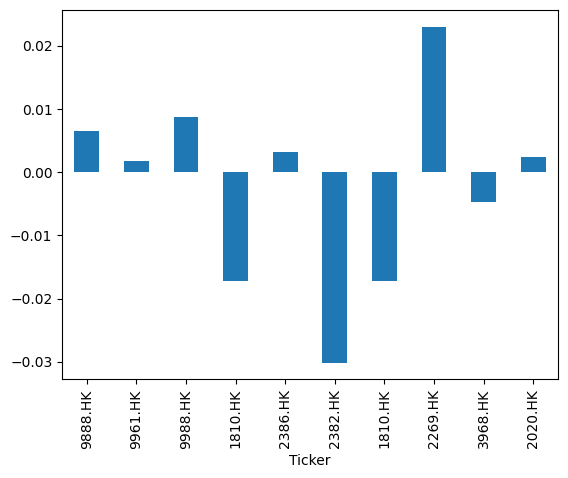

In [37]:
timie = -1
target = (pct_calculating_profit[holdings_gap.iloc[timie]+holdings.iloc[timie]].iloc[timie]-1)
target.plot(kind='bar')
target.name